In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
import matplotlib.pyplot as plt
import os

# Ising model optimization

### The model

We take an Ising model Hamiltonian as our example problem, where *J* and *g* describe the nearest and next-nearest neighbor interaction of an Ising spin chain of *n* qubits. A global control field in the x-direction *u(t)* is used for the control of the system.

$H(t) = - J \sum_{j}^{n} \sigma_j^z \sigma_{j+1}^z \; - g \sum_{j}^{n} \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_{j}^{n} \sigma_j^x \;$

## GRAPE Optimization with Automatic Differentiation (AD) using JAX

### Define the Model

The user must write a class that is a child of the AbstractFoM class provided by QuOCS to define the problem to be solved. It must contain at least a function called get_FoM which takes the pulses, parameters and times as lists of numpy arrays (or floats for the parameters) and returns a dictionary with the figure of merit (FoM) under the key "FoM". What happens inside the get_FoM function is up to the user. 

In this code one can define *J* and *g* and the number of qubits, as well as the desired initial and target state after evolution of the Hamiltonian under the control field *u(t)*. In get_FoM the pulses are taken to caluclate the evolution under above Hamiltonian and the propagator is applied to the initial state. The resulting final state is overlapped with the target state to extract to state fidelity. This is passed back as a FoM.

In [3]:
import numpy as np
import jax.numpy as jnp
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator_AD import pw_final_evolution_AD
from quocslib.utils.jax_utils import fidelity_funct as fidelity_funct_AD


def tensor_together(A):
    """Takes a list of matrices and multiplies them together with the tensor product"""
    res = np.kron(A[0], A[1])
    if len(A) > 2:
        for two in A[2:]:
            res = np.kron(res, two)
    else:
        res = res
    return res


def get_static_hamiltonian(nqu, J, g):
    """
    Get the static Hamiltonian for the Ising model
    :param nqu: Number of qubits
    :param J: Nearest neighbour coupling
    :param g: Next-nearest neighbour coupling
    :return: The Hamiltonian
    """
    dim = 2**nqu
    H0 = np.zeros((dim, dim), dtype=np.complex128)
    i2 = np.eye(2)
    sz = np.array([[1, 0], [0, -1]], dtype="complex")
    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        if j == nqu - 1:
            idx1 = j
            idx2 = 0
        else:
            idx1 = j
            idx2 = j + 1
        rest[idx1] = sz
        rest[idx2] = sz
        H0 = H0 - J * tensor_together(rest)

    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        if j == nqu - 1:
            idx1 = j
            idx2 = 1
        elif j == nqu - 2:
            idx1 = j
            idx2 = 0
        else:
            idx1 = j
            idx2 = j + 2
        rest[idx1] = sz
        rest[idx2] = sz
        H0 = H0 - g * tensor_together(rest)
    return H0


def get_control_hamiltonian(nqu: int):
    """"
    Get the control Hamiltonian for the Ising model
    :param nqu: Number of qubits
    :return: The Hamiltonian
    """
    dim = 2**nqu
    H_at_t = np.zeros((dim, dim), dtype=np.complex128)
    i2 = np.eye(2)
    sx = np.array([[0, 1], [1, 0]], dtype="complex")
    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        rest[j] = sx
        H_at_t = H_at_t + tensor_together(rest)
    return H_at_t


def get_initial_state(nqu: int):
    """
    Get the initial state for the Ising model
    :param nqu:
    :return: Initial state density matrix
    """
    rho0 = np.array([[1, 0], [0, 0]], dtype=np.complex128)
    state = [rho0] * nqu
    return tensor_together(state)


def get_target_state(nqu: int):
    """
    Get the target state for the Ising model
    :param nqu:
    :return: Target state density matrix
    """
    rhoT = np.array([[0, 0], [0, 1]], dtype=np.complex128)
    state = [rhoT] * nqu
    return tensor_together(state)


class IsingModel(AbstractFoM):
    """
    A figure of merit class for optimization of the problem defined by Alastair Marshall via
    https://arxiv.org/abs/2110.06187
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)
        self.n_slices = args_dict.setdefault("n_slices", 100)

        self.H_drift = jnp.asarray(get_static_hamiltonian(self.n_qubits, self.J, self.g))
        self.H_control = jnp.asarray(get_control_hamiltonian(self.n_qubits))
        self.rho_0 = jnp.asarray(get_initial_state(self.n_qubits))
        self.rho_target = jnp.asarray(get_target_state(self.n_qubits))
        self.rho_final = jnp.asarray(np.zeros_like(self.rho_target))

    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift

    def get_target_state(self):
        return self.rho_target

    def get_initial_state(self):
        return self.rho_0

    def get_propagator(self,
                       pulses_list: list = jnp.array,
                       time_grids_list: list = jnp.array,
                       parameters_list: list = jnp.array) -> np.array:
        """ Compute and return the list of propagators """
        # jax.debug.print(pulses_list)
        # jax.debug.print("get_propagator, pulses_list: {}", pulses_list)
        drive = pulses_list[0, :].reshape(1, len(pulses_list[0, :]))
        n_slices = self.n_slices
        time_grid = time_grids_list[0, :]
        dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        return pw_final_evolution_AD(drive, self.H_drift, [self.H_control], n_slices, dt, jnp.identity(2 ** self.n_qubits, dtype=np.complex128))

    def get_FoM(self,
                pulses: list = jnp.array,
                parameters: list = jnp.array,
                timegrids: list = jnp.array) -> dict:
        """
        Function to calculate the figure of merit from the pulses, parameters and timegrids.
        :param pulses: jnp.arrays of the pulses to be optimized.
        :param timegrids: jnp.arrays of the timegrids connected to the pulses.
        :param parameters: jnp.array of the parameters to be optimized.
        :return: dict - The figure of merit in a dictionary
        """
        U_final = self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        rho_final = U_final @ self.rho_0 @ U_final.T.conj()
        fidelity = fidelity_funct_AD(rho_final, self.rho_target)
        return {"FoM": fidelity}

### Define the configuration dictionary
This dictionary is passed to the QuOCS optimized in order to tell it what optimization algorithm to use. I also contains further settings for the optimization process.

First, we give the optimization a name, which will also appear in the name of the results folder generated.

In [4]:
optimization_dictionary = {"optimization_client_name": "IsingModel_AD"}

#### Settings for the optimization algorithm
The "algotithm_settings" key in gets a dictionary with the name of the algorithm. In this case we use the AD algorithm.

In [5]:
optimization_dictionary["algorithm_settings"] = {"algorithm_name": "AD"}

Now we define some settings for AD: Since we want to maximize the returned figure of merit (state overlap with the target), we set the optimization direction to "maximization".

In [6]:
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"

#### The Controls
The controls are given by a pulse in x-direction. Let's give it some limits, a discretization (100 bins) and an initial variation of the pulse amplitudes. For GRAPE one has to use the piecewise constant basis, so the variation is the change of each value of the amplitude in each time bin. Typically ~30\% of the maximal possible amplitude is a useful starting value. We also connect a time object named "time_1" (defined later) to the pulse to tell it about the duration of the pulse.

In [7]:
pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 100.0,
           "lower_limit": -100.0,
           "bins_number": 100,
           "amplitude_variation": 30.0,
           "time_name": "time_1"
           }

### The basis
The "basis" option for GRAPE has to be "PiecewiseBasis".

In [8]:
pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

#### The times
If there are several pulses on differen timescales, you can define different times here and link them to the pulses accordingly. In our case we have the aforementioned "time_1" which we set to 1.

In [9]:
time1 = {"time_name": "time_1",
         "initial_value": 1.0 }

Now, let's insert the controls in the optimization_dictionary

In [10]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

### Create the optimizer and run the optimization
All you need to do now is to import the Optimizer from QuOCS and create an optimization object by passing an instance of the FoM object (here IsingModel()) and the optimization_dictionary.

In [11]:
from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, IsingModel())

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     oc_logger    The optimization direction is maximization
INFO     oc_logger    Random number generator from the numpy library, version 1.23.5
WARNING  oc_logger    Seed number must be an integer value. Set 8368 as a seed numer for this optimization


To run the optimization, call the .execute() function on the optimization object.

In [12]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.55
INFO     oc_logger    New record achieved. Previous FoM: -10000000000, new best FoM : 0.15323367937123622
INFO     oc_logger    Function evaluation number: 1, FoM: 0.15323367937123622
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          100     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53234D-01    |proj g|=  1.65662D-02
INFO     oc_logger    New record achieved. Previous FoM: 0.15323367937123622, new best FoM : 0.24704180120118224
INFO     oc_logger    Function evaluation number: 2, FoM: 0.24704180120118224


 This problem is unconstrained.


INFO     oc_logger    New record achieved. Previous FoM: 0.24704180120118224, new best FoM : 0.4842868154957253
INFO     oc_logger    Function evaluation number: 3, FoM: 0.4842868154957253

At iterate    1    f= -4.84287D-01    |proj g|=  1.11776D-02
INFO     oc_logger    New record achieved. Previous FoM: 0.4842868154957253, new best FoM : 0.5845313987509325
INFO     oc_logger    Function evaluation number: 4, FoM: 0.5845313987509325

At iterate    2    f= -5.84531D-01    |proj g|=  1.26950D-02
INFO     oc_logger    New record achieved. Previous FoM: 0.5845313987509325, new best FoM : 0.6609400999651532
INFO     oc_logger    Function evaluation number: 5, FoM: 0.6609400999651532

At iterate    3    f= -6.60940D-01    |proj g|=  8.02203D-03
INFO     oc_logger    New record achieved. Previous FoM: 0.6609400999651532, new best FoM : 0.690300817135622
INFO     oc_logger    Function evaluation number: 6, FoM: 0.690300817135622

At iterate    4    f= -6.90301D-01    |proj g|=  7.00373D-03
I

INFO     oc_logger    Function evaluation number: 39, FoM: 0.9894153007689475

At iterate   32    f= -9.89415D-01    |proj g|=  5.66798D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9894153007689475, new best FoM : 0.9898096675290358
INFO     oc_logger    Function evaluation number: 40, FoM: 0.9898096675290358

At iterate   33    f= -9.89810D-01    |proj g|=  4.33705D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9898096675290358, new best FoM : 0.9900361299759955
INFO     oc_logger    Function evaluation number: 41, FoM: 0.9900361299759955

At iterate   34    f= -9.90036D-01    |proj g|=  5.01890D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9900361299759955, new best FoM : 0.9901466069752697
INFO     oc_logger    Function evaluation number: 42, FoM: 0.9901466069752697

At iterate   35    f= -9.90147D-01    |proj g|=  3.56286D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9901466069752697, new best FoM : 0.9902582529745

INFO     oc_logger    Function evaluation number: 74, FoM: 0.996303760034831

At iterate   64    f= -9.96304D-01    |proj g|=  3.95708D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.996303760034831, new best FoM : 0.9966337333203028
INFO     oc_logger    Function evaluation number: 75, FoM: 0.9966337333203028

At iterate   65    f= -9.96634D-01    |proj g|=  5.10784D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9966337333203028, new best FoM : 0.9968326766402889
INFO     oc_logger    Function evaluation number: 76, FoM: 0.9968326766402889
INFO     oc_logger    New record achieved. Previous FoM: 0.9968326766402889, new best FoM : 0.9969828939445953
INFO     oc_logger    Function evaluation number: 77, FoM: 0.9969828939445953

At iterate   66    f= -9.96983D-01    |proj g|=  7.91870D-04
INFO     oc_logger    New record achieved. Previous FoM: 0.9969828939445953, new best FoM : 0.9976415821763027
INFO     oc_logger    Function evaluation number: 78, FoM: 0

#### Results
Let us visualize the optimization by looking at the evolution of the FoM over the function evaluations and the final control pulse.

Text(0, 0.5, 'Amplitude')

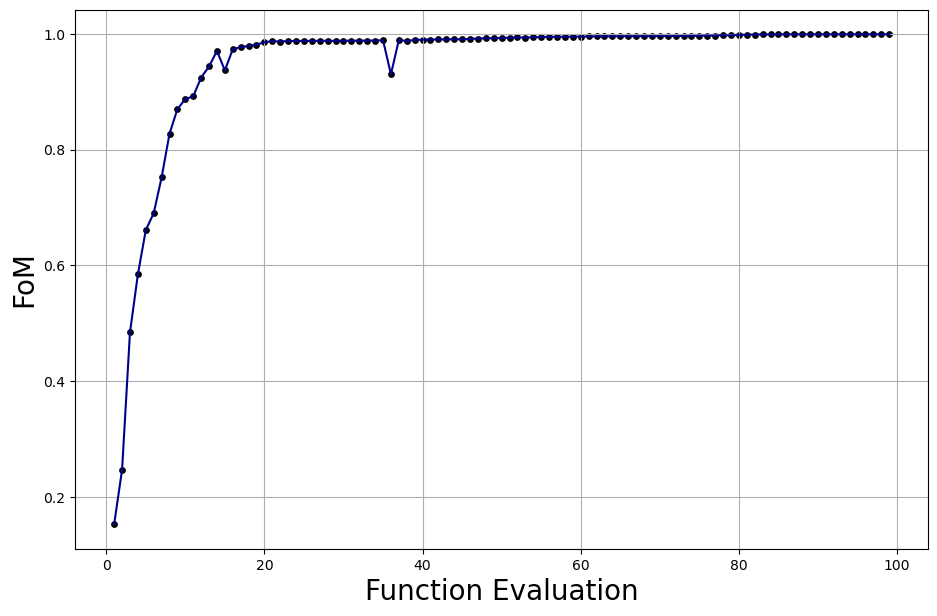

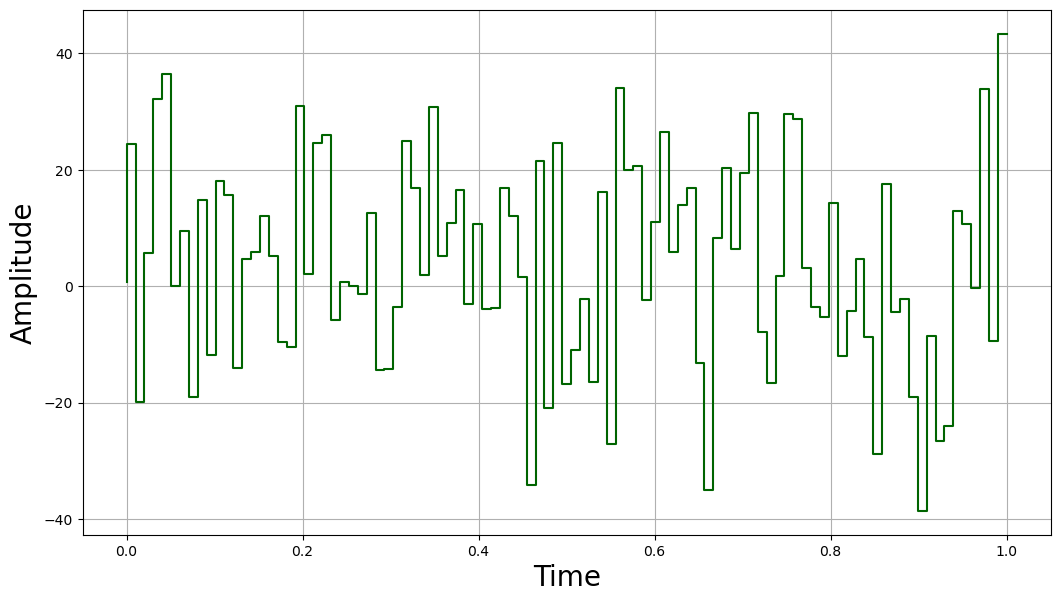

In [13]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be founf under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)